In [59]:
import nasdaqdatalink
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from data_loader import get_data, get_data_multiple

In [60]:
api_key = "4582031f930830a9e531b95f4f79f677"

In [61]:
target = get_data(api_key, "USREC")
target['USREC'] = target['USREC'].astype(float)
target.reset_index(inplace = True)
target = target.rename(columns = {'date': 'DATE'})

In [62]:
target

,DATE,USREC
0,1854-12-01,1.0
1,1855-01-01,0.0
2,1855-02-01,0.0
3,1855-03-01,0.0
4,1855-04-01,0.0
...,...,...
2012,2022-08-01,0.0
2013,2022-09-01,0.0
2014,2022-10-01,0.0
2015,2022-11-01,0.0


In [63]:
ten_year_treas = get_data(api_key, "DGS10")
ten_year_treas = ten_year_treas.rename(columns = {'DGS10': 'Value'})
three_month_treas = get_data(api_key, "DTB3")
three_month_treas = three_month_treas.rename(columns = {'DTB3': 'Value'})
combined = three_month_treas.join(ten_year_treas, how='left', lsuffix='_3mon', rsuffix='_10yr')
combined = combined.dropna()
# drop all rows where the value is just "."
combined = combined[combined.Value_3mon != "."]
combined = combined[combined.Value_10yr != "."]
# export combined to csv
combined.to_csv('combined.csv')
# convert columns to float64
combined['Value_3mon'] = combined['Value_3mon'].astype('float64')
combined['Value_10yr'] = combined['Value_10yr'].astype('float64')
# create new column for spread
combined['spread'] = combined['Value_10yr'] - combined['Value_3mon']

In [64]:
combined

,Value_3mon,Value_10yr,spread
date,,,
1962-01-02,2.70,4.06,1.36
1962-01-03,2.73,4.03,1.30
1962-01-04,2.72,3.99,1.27
1962-01-05,2.74,4.02,1.28
1962-01-08,2.78,4.03,1.25
...,...,...,...
2023-01-18,4.54,3.37,-1.17
2023-01-19,4.55,3.39,-1.16
2023-01-20,4.57,3.48,-1.09


In [65]:
# take average by month in yield
yield_by_month_mean = combined.resample('M').mean()
# format yield into monthly datetime
yield_by_month_mean.index = yield_by_month_mean.index.strftime('%Y-%m')


In [66]:
#Take average by month in yield
yield_by_month_mean = combined.groupby(pd.Grouper(freq='M')).mean()

#Format yield into monthly datetime
yield_by_month_mean = yield_by_month_mean.set_index(yield_by_month_mean.index.strftime('%Y-%m'))

#Format target into YYYY-MM
target['DATE'] = target['DATE'].apply(lambda x: x.strftime('%Y-%m'))
target = target.set_index(target['DATE']).drop(columns = ['DATE'])

<AxesSubplot:xlabel='date'>

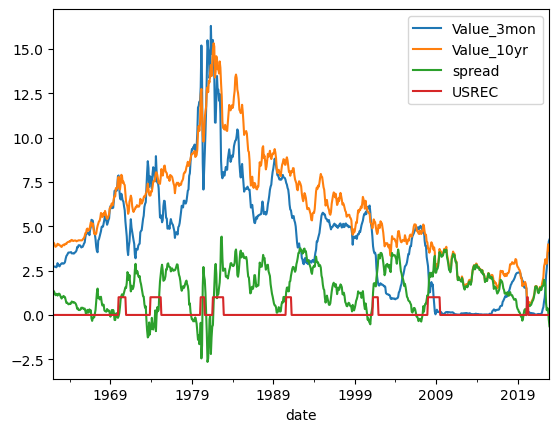

In [67]:
recession_vs_yield = yield_by_month_mean.join(target, how = 'left').dropna()
recession_vs_yield = recession_vs_yield.set_index(pd.DatetimeIndex(recession_vs_yield.index))
recession_vs_yield.plot()

In [68]:
recession_vs_yield.dtypes

Value_3mon    float64
Value_10yr    float64
spread        float64
USREC         float64
dtype: object

In [69]:
nasdaqdatalink.read_key("/data/.apikey")
SOC35 = nasdaqdatalink.get('UMICH/SOC35')
#Include michigan state university data on current levels of fear WRT the economy
SOC35 = SOC35.set_index(SOC35.index.strftime('%Y-%m'))
date_index = recession_vs_yield.index.strftime('%Y-%m')
recession_vs_yield = recession_vs_yield.set_index(date_index)
recession_vs_yield = SOC35.join(recession_vs_yield, how = 'right')

In [70]:
recession_vs_yield

,Good time to buy,Uncertain - depends,Bad time to buy,Relative,Value_3mon,Value_10yr,spread,USREC
date,,,,,,,,
1962-01,NaN,NaN,NaN,NaN,2.719545,4.083182,1.363636,0.0
1962-02,NaN,NaN,NaN,NaN,2.732778,4.039444,1.306667,0.0
1962-03,NaN,NaN,NaN,NaN,2.723182,3.930455,1.207273,0.0
1962-04,NaN,NaN,NaN,NaN,2.729500,3.843000,1.113500,0.0
1962-05,NaN,NaN,NaN,NaN,2.685000,3.873636,1.188636,0.0
...,...,...,...,...,...,...,...,...
2022-08,32.0,5.0,63.0,69.0,2.630870,2.897826,0.266957,0.0
2022-09,34.0,5.0,61.0,73.0,3.126667,3.519048,0.392381,0.0
2022-10,42.0,6.0,52.0,90.0,3.717000,3.983500,0.266500,0.0


In [71]:
unemployment = get_data(api_key, "UNRATE")

In [72]:
if unemployment.index.dtype == 'datetime64[ns]':
    unemployment.index = unemployment.index.strftime('%Y-%m')
combined2 = recession_vs_yield.join(unemployment, how = 'left')

In [73]:
combined2

,Good time to buy,Uncertain - depends,Bad time to buy,Relative,Value_3mon,Value_10yr,spread,USREC,UNRATE
date,,,,,,,,,
1962-01,NaN,NaN,NaN,NaN,2.719545,4.083182,1.363636,0.0,5.8
1962-02,NaN,NaN,NaN,NaN,2.732778,4.039444,1.306667,0.0,5.5
1962-03,NaN,NaN,NaN,NaN,2.723182,3.930455,1.207273,0.0,5.6
1962-04,NaN,NaN,NaN,NaN,2.729500,3.843000,1.113500,0.0,5.6
1962-05,NaN,NaN,NaN,NaN,2.685000,3.873636,1.188636,0.0,5.5
...,...,...,...,...,...,...,...,...,...
2022-08,32.0,5.0,63.0,69.0,2.630870,2.897826,0.266957,0.0,3.7
2022-09,34.0,5.0,61.0,73.0,3.126667,3.519048,0.392381,0.0,3.5
2022-10,42.0,6.0,52.0,90.0,3.717000,3.983500,0.266500,0.0,3.7


In [74]:
housing_market_data = nasdaqdatalink.get('YALE/RHPI')
housing_market_data = housing_market_data.rename(columns = {'Index': 'Yale_Housing'})

In [75]:
fred_housing = get_data(api_key, "CSUSHPINSA")
fred_housing = fred_housing[fred_housing.CSUSHPINSA != "."]
fred_housing['CSUSHPINSA'] = fred_housing['CSUSHPINSA'].astype(float)
fred_housing = fred_housing.rename(columns = {'CSUSHPINSA': 'FRED_Housing'})

In [76]:
# adjust index to match other data
fred_housing.index = fred_housing.index.strftime('%Y-%m')
housing_market_data.index = housing_market_data.index.strftime('%Y-%m')
combined_housing = fred_housing.join(housing_market_data, how = 'left')

In [77]:
combined_housing

,FRED_Housing,Yale_Housing
date,,
1987-01,63.734,122.638054
1987-02,64.134,122.963501
1987-03,64.469,123.056393
1987-04,64.973,123.360053
1987-05,65.547,124.009712
...,...,...
2022-06,308.371,NaN
2022-07,307.177,NaN
2022-08,303.706,NaN


<AxesSubplot:xlabel='date'>

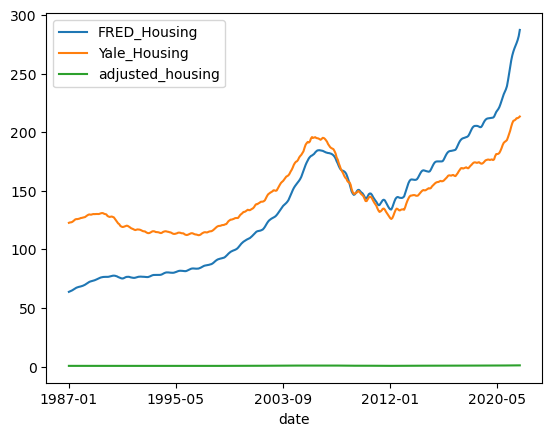

In [78]:
#adjust fred housing with cpi
cpi = get_data(api_key, "CPIAUCSL")
cpi = cpi.rename(columns = {'CPIAUCSL': 'Value'})
cpi = cpi.set_index(cpi.index.strftime('%Y-%m'))
cpi = cpi.join(combined_housing, how = 'left')
cpi = cpi.dropna()
cpi['Value'] = cpi['Value'].astype(float)
cpi['FRED_Housing'] = cpi['FRED_Housing'].astype(float)
cpi['adjusted_housing'] = (cpi['FRED_Housing']/ cpi['Value'])
cpi = cpi.drop(columns = ['Value'])
cpi.plot()

In [79]:
from sklearn.linear_model import LinearRegression

# do linear regression to get scaling factor between fred and yale
X = cpi['adjusted_housing'].values.reshape(-1, 1)
y = cpi['Yale_Housing'].values.reshape(-1, 1)
reg = LinearRegression().fit(X, y)
reg.score(X, y)
reg.coef_[0][0]

213.0298949761555

In [80]:
cpi_series = get_data(api_key, "CPIAUCSL")
cpi_series = cpi_series.set_index(cpi_series.index.strftime('%Y-%m'))
#adjusted_housing = fred_housing * reg.coef_[0][0] / cpi_series

In [81]:
adjusted_housing = fred_housing.join(cpi_series, how='left')
adjusted_housing['CPIAUCSL'] = adjusted_housing['CPIAUCSL'].astype(float)
adjusted_housing['FRED_Housing'] = adjusted_housing['FRED_Housing'].astype(float)
# remove all rows where CPIAUCSL is NaN or FRED_Housing is '.'ArithmeticError
#adjusted_housing = adjusted_housing[adjusted_housing.CPIAUCSL.notna()]
adjusted_housing = adjusted_housing[adjusted_housing.FRED_Housing != "."]
adjusted_housing.dtypes
adjusted_housing['adjusted_housing'] = (adjusted_housing['FRED_Housing'] * reg.coef_[0][0] / adjusted_housing['CPIAUCSL']).astype(float)
adjusted_housing

,FRED_Housing,CPIAUCSL,adjusted_housing
date,,,
1987-01,63.734,111.400,121.878342
1987-02,64.134,111.800,122.204466
1987-03,64.469,112.200,122.404851
1987-04,64.973,112.700,122.814475
1987-05,65.547,113.000,123.570536
...,...,...,...
2022-06,308.371,295.328,222.438244
2022-07,307.177,295.271,221.619746
2022-08,303.706,295.620,218.856834


In [82]:
combined_housing

,FRED_Housing,Yale_Housing
date,,
1987-01,63.734,122.638054
1987-02,64.134,122.963501
1987-03,64.469,123.056393
1987-04,64.973,123.360053
1987-05,65.547,124.009712
...,...,...
2022-06,308.371,NaN
2022-07,307.177,NaN
2022-08,303.706,NaN


In [83]:
# drop everything after 1987-01
housing_market_data = housing_market_data[housing_market_data.index < '1987-01']
# concat with adjusted housing
adjusted_housing = pd.concat([housing_market_data['Yale_Housing'], adjusted_housing['adjusted_housing']], axis = 0)
adjusted_housing = adjusted_housing.to_frame(name='adjusted_housing')
adjusted_housing = adjusted_housing.set_index(pd.to_datetime(adjusted_housing.index).strftime('%Y-%m'))
adjusted_housing

,adjusted_housing
1890-12,100.000000
1891-12,88.011791
1892-12,95.421736
1893-12,92.297385
1894-12,123.980483
...,...
2022-06,222.438244
2022-07,221.619746
2022-08,218.856834
2022-09,215.777107


In [101]:
combined3 = combined2.join(adjusted_housing, how = 'left')
combined3 = combined3.rename(columns = {'adjusted_housing': 'housing market', 'UNRATE': 'Value'})
# rename the date index column to Date
combined3 = combined3.rename_axis('Date')

In [102]:
combined3.isna().sum()

Good time to buy       192
Uncertain - depends    192
Bad time to buy        192
Relative               192
Value_3mon               0
Value_10yr               0
spread                   0
USREC                    0
Value                    0
housing market           2
dtype: int64

In [103]:
combined3

,Good time to buy,Uncertain - depends,Bad time to buy,Relative,Value_3mon,Value_10yr,spread,USREC,Value,housing market
Date,,,,,,,,,,
1962-01,NaN,NaN,NaN,NaN,2.719545,4.083182,1.363636,0.0,5.8,109.981774
1962-02,NaN,NaN,NaN,NaN,2.732778,4.039444,1.306667,0.0,5.5,109.380905
1962-03,NaN,NaN,NaN,NaN,2.723182,3.930455,1.207273,0.0,5.6,109.380905
1962-04,NaN,NaN,NaN,NaN,2.729500,3.843000,1.113500,0.0,5.6,109.018717
1962-05,NaN,NaN,NaN,NaN,2.685000,3.873636,1.188636,0.0,5.5,109.605470
...,...,...,...,...,...,...,...,...,...,...
2022-08,32.0,5.0,63.0,69.0,2.630870,2.897826,0.266957,0.0,3.7,218.856834
2022-09,34.0,5.0,61.0,73.0,3.126667,3.519048,0.392381,0.0,3.5,215.777107
2022-10,42.0,6.0,52.0,90.0,3.717000,3.983500,0.266500,0.0,3.7,213.693152


In [104]:
combined3.to_csv('preprocessed_data.csv')